In [1]:
#!/usr/bin/env python
#
#  Author: Andreas Brotzer (2024)
# -------------------------------------------------------------------------

In [2]:
import os
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from obspy import UTCDateTime
from pandas import read_csv, date_range


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [70]:
config = {}

config['sta'] = "VROMY"

config['tbeg'] = "2024-07-01"
config['tend'] = "2024-09-15"

config['project'] = "rolode"

config['path_to_conf'] = data_path+"VelocityChanges/data/VROMY/sds/"

config['path'] = data_path+f"VelocityChanges/data/VROMY/{config['project']}/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"

# config['name'] = f"{config['project']}_{str(UTCDateTime(config['tbeg']).date).replace('-','')}"

config['col_names'] = ["frequency", "mean", "std", "mode", "median"]

config['dates'] = date_range(config['tbeg'], config['tend'])
config['dates'] = [str(_d)[:10].replace('-', '') for _d in config['dates']]

cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(config['dates'])))
config['date_colors'] = {_d:_c for _d, _c in zip(config['dates'], colors)}


In [71]:
def __load_dispersion(mode="Love"):

    from pandas import DataFrame, concat, read_csv

    # df = DataFrame()
    data = {}

    dates = date_range(config['tbeg'], config['tend'])

    for _n, _date in enumerate(dates):

        _date_str = str(_date)[:10].replace('-','')

        filename = f"{config['project']}_{_date_str}_{mode}/"

        if os.path.isdir(config['path']+filename):
            try:
                df0 = read_csv(config['path']+f"{filename}"+"results.csv",
                               delimiter=",", header=0, names=config['col_names']
                              )
                data[_date_str] = df0
            except Exception as e:
                print(e)
        else:
            print(f"-> no file for {filename}")

    return data

In [72]:
data_love = __load_dispersion("Love")

-> no file for rolode_20240701_Love/
-> no file for rolode_20240720_Love/
-> no file for rolode_20240721_Love/
-> no file for rolode_20240722_Love/
-> no file for rolode_20240723_Love/
-> no file for rolode_20240724_Love/
-> no file for rolode_20240725_Love/
-> no file for rolode_20240730_Love/
-> no file for rolode_20240731_Love/
-> no file for rolode_20240805_Love/
-> no file for rolode_20240806_Love/
-> no file for rolode_20240807_Love/
-> no file for rolode_20240808_Love/
-> no file for rolode_20240809_Love/
[Errno 2] No such file or directory: '/home/andbro/kilauea-data/VelocityChanges/data/VROMY/rolode/rolode_20240816_Love/results.csv'
[Errno 2] No such file or directory: '/home/andbro/kilauea-data/VelocityChanges/data/VROMY/rolode/rolode_20240817_Love/results.csv'
-> no file for rolode_20240818_Love/
-> no file for rolode_20240819_Love/
-> no file for rolode_20240820_Love/
-> no file for rolode_20240821_Love/
-> no file for rolode_20240824_Love/
-> no file for rolode_20240825_Lo

In [73]:
data_rayl = __load_dispersion("Rayleigh2")

-> no file for rolode_20240701_Rayleigh2/
-> no file for rolode_20240720_Rayleigh2/
-> no file for rolode_20240721_Rayleigh2/
-> no file for rolode_20240722_Rayleigh2/
-> no file for rolode_20240723_Rayleigh2/
-> no file for rolode_20240724_Rayleigh2/
-> no file for rolode_20240725_Rayleigh2/
-> no file for rolode_20240730_Rayleigh2/
-> no file for rolode_20240731_Rayleigh2/
-> no file for rolode_20240805_Rayleigh2/
-> no file for rolode_20240806_Rayleigh2/
-> no file for rolode_20240807_Rayleigh2/
-> no file for rolode_20240808_Rayleigh2/
-> no file for rolode_20240809_Rayleigh2/
-> no file for rolode_20240816_Rayleigh2/
-> no file for rolode_20240817_Rayleigh2/
-> no file for rolode_20240818_Rayleigh2/
-> no file for rolode_20240819_Rayleigh2/
-> no file for rolode_20240820_Rayleigh2/
-> no file for rolode_20240821_Rayleigh2/
-> no file for rolode_20240824_Rayleigh2/
-> no file for rolode_20240825_Rayleigh2/
-> no file for rolode_20240826_Rayleigh2/
-> no file for rolode_20240827_Ray

### Plotting

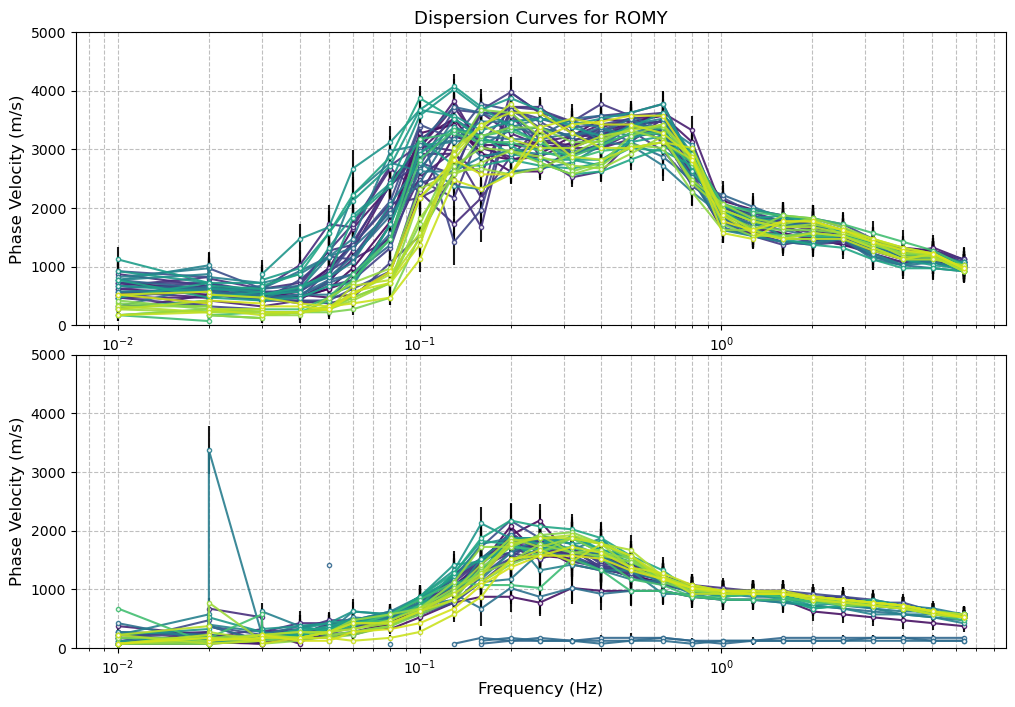

In [74]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    for _i, k in enumerate(data_love.keys()):

        _data = data_love[k]
        _data.dropna(inplace=True)

        try:
            ax[0].errorbar(_data['frequency'].astype(float),
                           _data['median'].astype(float),
                           yerr=_data['std'].astype(float),
                           ls="-", ms=3, marker="o", label=k,
                           ecolor="k", markerfacecolor="w",
                           color=config['date_colors'][k], alpha=0.9
                           )
        except:
            pass

    for _i, k in enumerate(data_rayl.keys()):

        _data = data_rayl[k]
        _data.dropna(inplace=True)

        try:
            ax[1].errorbar(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float)),
                           yerr=_data['std'].astype(float),
                           ls="-", ms=3, marker="o", label=k,
                           ecolor="k", markerfacecolor="w",
                           color=config['date_colors'][k], alpha=0.9
                           )
        except Exception as e:
            print(e)
            pass

    for n in range(2):
        ax[n].set_xscale("log")

        ax[n].set_ylim(0, 5000)

        ax[n].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        # ax[n].legend(loc=1)

    ax[0].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_title("Dispersion Curves for ROMY", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"Dispersion_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


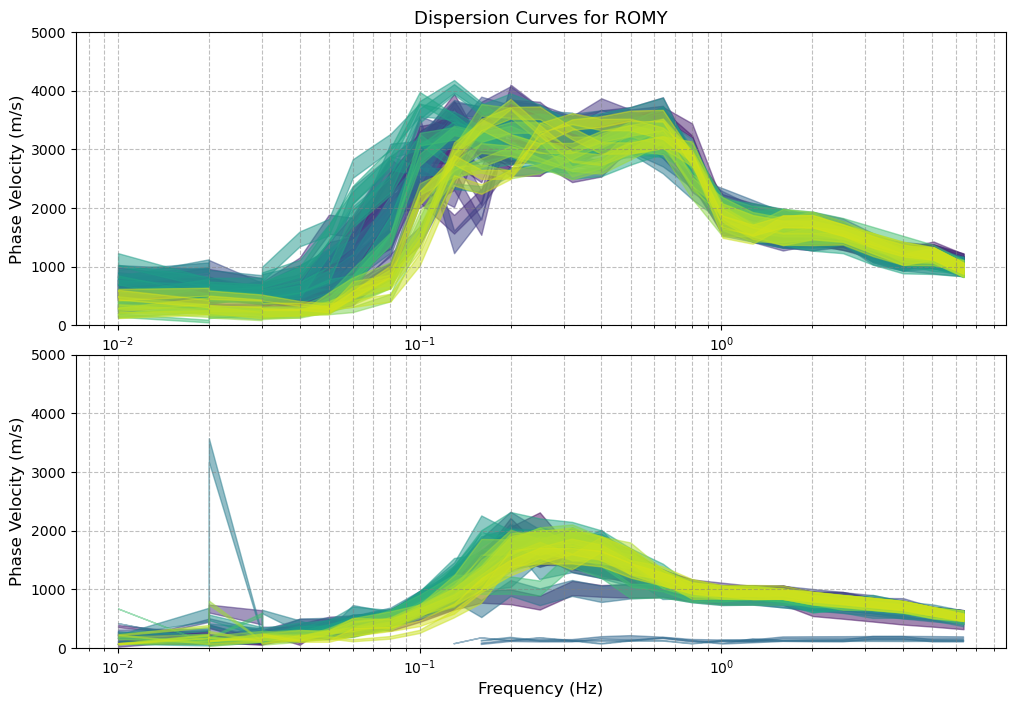

In [83]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    for _i, k in enumerate(data_love.keys()):

        _data = data_love[k]
        _data.dropna(inplace=True)

        try:
            ax[0].fill_between(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float))-_data['std'].astype(float)/2,
                           np.array(_data['median'].astype(float))+_data['std'].astype(float)/2,
                           color=config['date_colors'][k], alpha=0.5
                           )
        except:
            pass

    for _i, k in enumerate(data_rayl.keys()):

        _data = data_rayl[k]
        _data.dropna(inplace=True)

        try:
            ax[1].fill_between(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float))-_data['std'].astype(float)/2,
                           np.array(_data['median'].astype(float))+_data['std'].astype(float)/2,
                           color=config['date_colors'][k], alpha=0.5
                           )

        except Exception as e:
            print(e)
            pass

    for n in range(2):

        ax[n].set_xscale("log")

        ax[n].set_ylim(0, 5000)

        ax[n].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        # ax[n].legend(loc=1)

    ax[0].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_title("Dispersion Curves for ROMY", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"Dispersion_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


In [91]:
round(653/109)

6

In [90]:
test = np.arange(0, 653)
len(test[::6])

131